In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from scipy.stats import binomtest
from pard.grantham import grantham
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import ConnectionPatch

In [12]:
df = pd.read_csv('../data/All_mutation_information.csv.gz')

C:\Users\voron\AppData\Local\Temp\ipykernel_25340\3160139400.py:1: DtypeWarning: Columns (13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/All_mutation_information.csv.gz')


In [13]:
ns_mut_df = df[df['(SBS) is nonsynonymous'].isin(['TRUE', 'True'])]
ns_mut_df = ns_mut_df[ns_mut_df['base(s) in status 1'].isin(['A', 'T', 'G', 'C']) & ns_mut_df['base(s) in status 2'].isin(['A', 'T', 'G', 'C'])]

In [14]:
ns_mut_df['codon_from'] = ns_mut_df['(SBS) AA change'].str.split(" ").str[1].str[0]
ns_mut_df['codon_to'] = ns_mut_df['(SBS) AA change'].str.split(" ").str[1].str[-1]
ns_mut_df['codon_Mut'] = ns_mut_df['codon_from'] + '>' + ns_mut_df['codon_to']
ns_mut_df['Mut'] = ns_mut_df['base(s) in status 1'] + '>' + ns_mut_df['base(s) in status 2']
#mut_with_aa = ns_mut_df[['codon_Mut', 'Mut']]
#mut_with_aa = mut_with_aa.drop_duplicates()

In [15]:
df_aa_mut = ns_mut_df.pivot_table(index=['codon_Mut', 'Mut'],values='position in refseq (one_based)', aggfunc='count').reset_index()

In [16]:
df_aa_mut

,codon_Mut,Mut,position in refseq (one_based)
0,*>E,T>G,3
1,*>G,T>G,3
2,*>K,T>A,4
3,*>L,A>T,2
4,*>L,G>T,2
...,...,...,...
225,Y>D,T>G,12
226,Y>F,A>T,35
227,Y>H,T>C,197
228,Y>N,T>A,16


In [17]:
df_aa_mut['Anti_codon_Mut'] = ''
df_aa_mut['Anti_codon_Mut_count'] = 0
for index, row in df_aa_mut.iterrows():
    second = df_aa_mut['codon_Mut'][index].split('>')[1]
    first = df_aa_mut['codon_Mut'][index].split('>')[0]
    df_aa_mut['Anti_codon_Mut'][index] = second+'>'+first
    
    second_mut = df_aa_mut['Mut'][index].split('>')[1]
    first_mut = df_aa_mut['Mut'][index].split('>')[0]
    anti_mut = second_mut+'>'+first_mut
    try:
        df_aa_mut['Anti_codon_Mut_count'][index] = df_aa_mut[((df_aa_mut['codon_Mut'] == df_aa_mut['Anti_codon_Mut'][index]) & (df_aa_mut['Mut'] == anti_mut))]['position in refseq (one_based)']
    except:
        print('Нет таких мутаций', second+'>'+first)

Нет таких мутаций R>*
Нет таких мутаций *>C
Нет таких мутаций *>C
Нет таких мутаций *>R
Нет таких мутаций S>R
Нет таких мутаций *>S
Нет таких мутаций *>S
Нет таких мутаций *>Y


C:\Users\voron\AppData\Local\Temp\ipykernel_25340\3029352120.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aa_mut['Anti_codon_Mut'][index] = second+'>'+first
C:\Users\voron\AppData\Local\Temp\ipykernel_25340\3029352120.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aa_mut['Anti_codon_Mut_count'][index] = df_aa_mut[((df_aa_mut['codon_Mut'] == df_aa_mut['Anti_codon_Mut'][index]) & (df_aa_mut['Mut'] == anti_mut))]['position in refseq (one_based)']


In [18]:
df_aa_mut

,codon_Mut,Mut,position in refseq (one_based),Anti_codon_Mut,Anti_codon_Mut_count
0,*>E,T>G,3,E>*,472
1,*>G,T>G,3,G>*,59
2,*>K,T>A,4,K>*,30
3,*>L,A>T,2,L>*,18
4,*>L,G>T,2,L>*,34
...,...,...,...,...,...
225,Y>D,T>G,12,D>Y,1232
226,Y>F,A>T,35,F>Y,29
227,Y>H,T>C,197,H>Y,799
228,Y>N,T>A,16,N>Y,36


In [19]:
df_aa_mut['direct_vs_reverse'] = df_aa_mut['position in refseq (one_based)'] / df_aa_mut['Anti_codon_Mut_count']

In [20]:
df_aa_mut.replace([np.inf, -np.inf], np.nan, inplace=True)
df_aa_mut = df_aa_mut.dropna().reset_index(drop=True)

In [21]:
df_aa_mut['pvalue'] = 0
df_aa_mut['cilow'] = 0
df_aa_mut['cihigh'] = 0
df_aa_mut['gran_dist'] = 0
df_aa_mut['prob_success'] = 0
df_aa_mut['codonParent'] = df_aa_mut['codon_Mut'].astype(str).str.split('>').str[0]
df_aa_mut['codonChild'] = df_aa_mut['codon_Mut'].astype(str).str.split('>').str[1]

In [22]:
df_aa_mut = df_aa_mut[(df_aa_mut['codonParent'] != '*') & (df_aa_mut['codonChild'] != '*')]

In [23]:
df_aa_mut.head()

,codon_Mut,Mut,position in refseq (one_based),Anti_codon_Mut,Anti_codon_Mut_count,direct_vs_reverse,pvalue,cilow,cihigh,gran_dist,prob_success,codonParent,codonChild
10,A>D,C>A,51,D>A,86,0.593023,0,0,0,0,0,A,D
11,A>E,C>A,22,E>A,49,0.448980,0,0,0,0,0,A,E
12,A>G,C>G,24,G>A,28,0.857143,0,0,0,0,0,A,G
13,A>P,G>C,32,P>A,13,2.461538,0,0,0,0,0,A,P
14,A>S,G>T,1473,S>A,88,16.738636,0,0,0,0,0,A,S


In [24]:
for index, row in df_aa_mut.iterrows():
    df_aa_mut['pvalue'][index] = binomtest(df_aa_mut['position in refseq (one_based)'][index], 
                                      n=df_aa_mut['position in refseq (one_based)'][index]+df_aa_mut['Anti_codon_Mut_count'][index], 
                                      p=0.5, alternative='two-sided').pvalue
    df_aa_mut['cilow'][index] = binomtest(df_aa_mut['position in refseq (one_based)'][index], 
                                      n=df_aa_mut['position in refseq (one_based)'][index]+df_aa_mut['Anti_codon_Mut_count'][index], 
                                      p=0.5, alternative='two-sided').proportion_ci(confidence_level=0.95).low
    df_aa_mut['cihigh'][index] = binomtest(df_aa_mut['position in refseq (one_based)'][index], 
                                      n=df_aa_mut['position in refseq (one_based)'][index]+df_aa_mut['Anti_codon_Mut_count'][index], 
                                      p=0.5, alternative='two-sided').proportion_ci(confidence_level=0.95).high
    df_aa_mut['gran_dist'][index] = grantham(df_aa_mut['codonParent'][index], df_aa_mut['codonChild'][index])
    
    df_aa_mut['prob_success'][index] = binomtest(df_aa_mut['position in refseq (one_based)'][index], 
                                      n=df_aa_mut['position in refseq (one_based)'][index]+df_aa_mut['Anti_codon_Mut_count'][index], 
                                      p=0.5, alternative='two-sided').statistic

C:\Users\voron\AppData\Local\Temp\ipykernel_25340\2757896041.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aa_mut['gran_dist'][index] = grantham(df_aa_mut['codonParent'][index], df_aa_mut['codonChild'][index])


In [25]:
df_aa_mut = df_aa_mut.reset_index(drop=True)
df_aa_mut['aster'] = ''
df_aa_mut.loc[df_aa_mut['pvalue'] <= 0.05,'aster'] = '*'
df_aa_mut.loc[df_aa_mut['pvalue'] <= 0.01,'aster'] = '**'
df_aa_mut.loc[df_aa_mut['pvalue'] <= 0.001,'aster'] = '***'

In [26]:
df_aa_mut = df_aa_mut.sort_values(by='gran_dist', ascending=False).reset_index(drop=True)

In [27]:
df_aa_mut = df_aa_mut.rename(columns={"position in refseq (one_based)": "Aa_Mut_count"})

In [28]:
df_aa_mut = df_aa_mut[df_aa_mut['Mut'].isin(["A>C", "A>G", "A>T", "C>G", "C>T",  "G>T"])]

In [29]:
df_aa_mut

,codon_Mut,Mut,Aa_Mut_count,Anti_codon_Mut,Anti_codon_Mut_count,direct_vs_reverse,pvalue,cilow,cihigh,gran_dist,prob_success,codonParent,codonChild,aster
2,C>W,C>G,1,W>C,3,0.333333,6.250000e-01,0.006309,0.805880,215,0.250000,C,W,
3,W>C,G>T,50,C>W,1,50.000000,4.618528e-14,0.895525,0.999504,215,0.980392,W,C,***
5,C>F,G>T,249,F>C,32,7.781250,8.170351e-43,0.843052,0.920790,205,0.886121,C,F,***
6,Y>C,A>G,189,C>Y,42,4.500000,1.858600e-23,0.762288,0.865707,194,0.818182,Y,C,***
9,G>W,G>T,1,W>G,1,1.000000,1.000000e+00,0.012579,0.987421,184,0.500000,G,W,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,M>I,G>T,1162,I>M,29,40.068966,0.000000e+00,0.965216,0.983634,10,0.975651,M,I,***
196,I>M,C>G,11,M>I,52,0.211538,1.673499e-07,0.090519,0.290971,10,0.174603,I,M,***
197,I>M,A>G,77,M>I,189,0.407407,4.875734e-12,0.235713,0.347995,10,0.289474,I,M,***
200,I>L,A>T,27,L>I,11,2.454545,1.385297e-02,0.540968,0.845754,5,0.710526,I,L,*


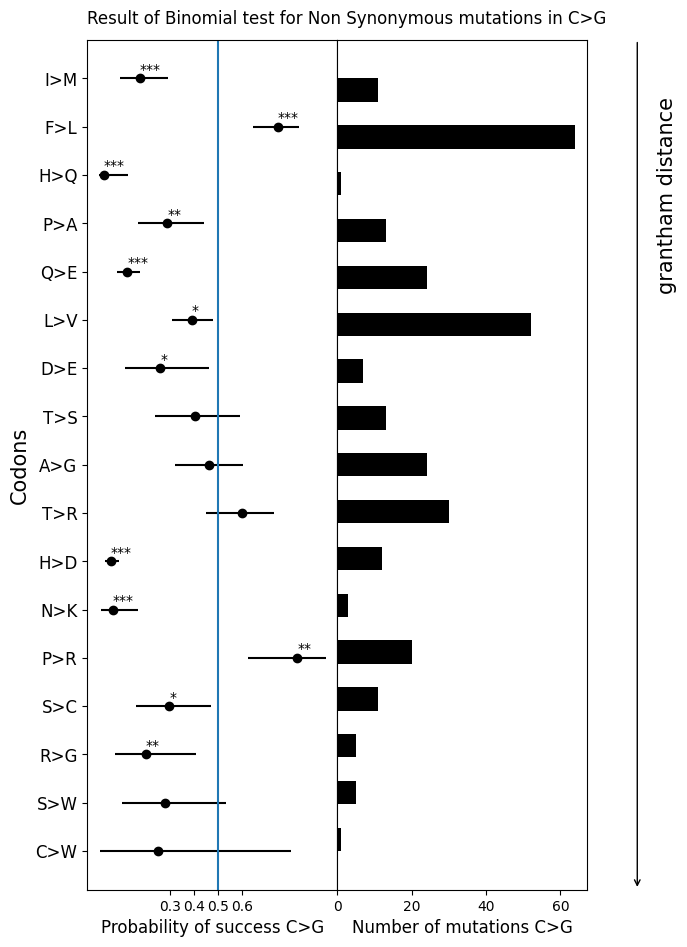

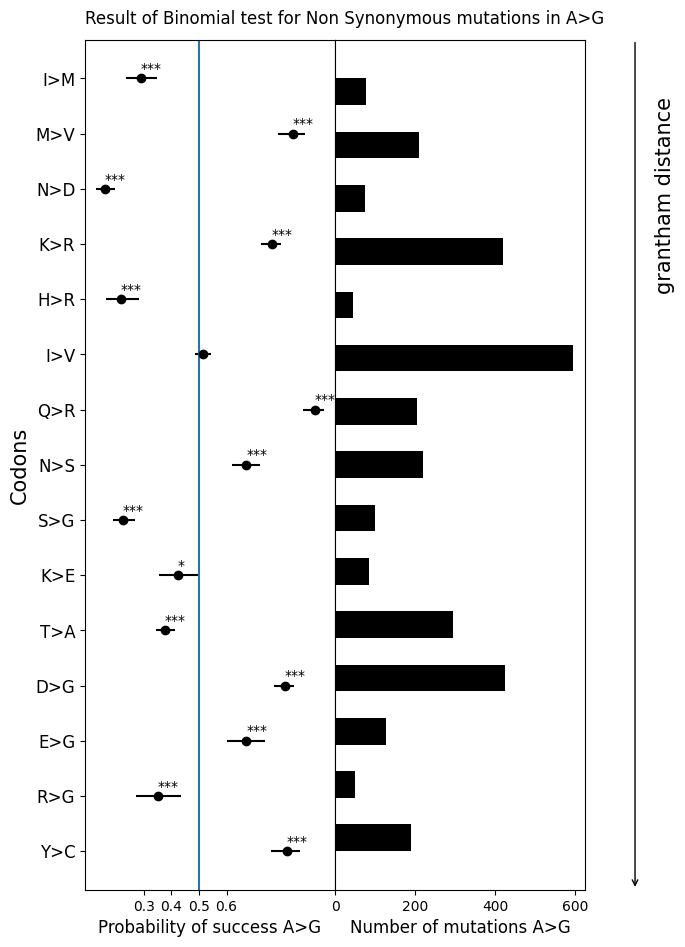

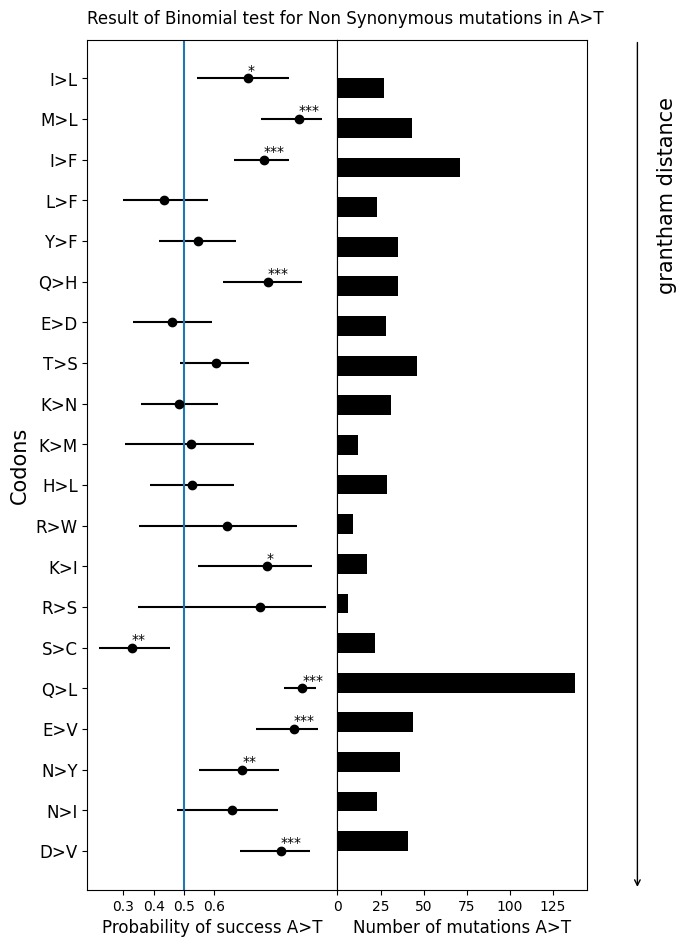

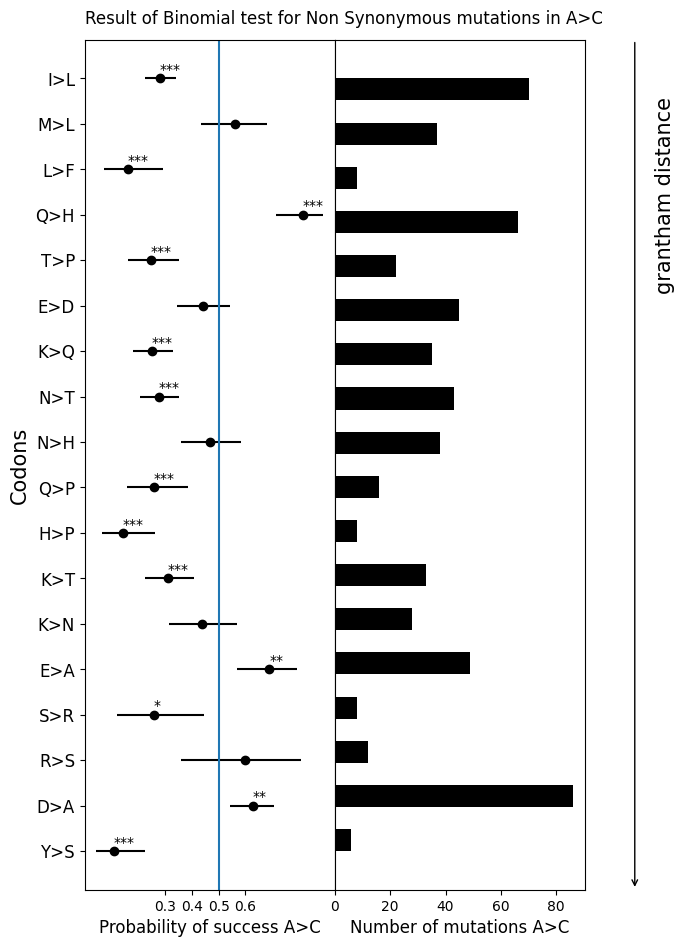

In [103]:
with PdfPages('../figures/binom_test_all_AA.pdf') as pdf:
    for mut in df_aa_mut['Mut'].unique():
        if mut != "C>T" and mut != "G>T":
            df_aa_mut_sub = df_aa_mut[df_aa_mut['Mut']==mut].reset_index(drop=True)
            fig, ax = plt.subplots(1,2,figsize=(10,10))
            min_error = list(df_aa_mut_sub['prob_success'] - df_aa_mut_sub['cilow'])
            max_error = list(df_aa_mut_sub['cihigh'] - df_aa_mut_sub['prob_success'])
            error = []
            for i in range(len(min_error)):
                error.append([min_error[i], max_error[i]])
            error = np.array(error)
            df_aa_mut_sub['color'] = ''
            df_aa_mut_sub.loc[df_aa_mut_sub['Mut']=='C>T', 'color'] = 'black'
            df_aa_mut_sub.loc[df_aa_mut_sub['Mut']=='G>T', 'color'] = 'black'
            df_aa_mut_sub.loc[~df_aa_mut_sub['Mut'].isin(['C>T', 'G>T']), 'color'] = 'black'

            for i in range(len(df_aa_mut_sub['color'])):
                er = ax[0].errorbar(df_aa_mut_sub['prob_success'][i], i, xerr=error[i].reshape(2, -1), marker="o", 
                                    linestyle="none", color=df_aa_mut_sub['color'][i])

            ax[0].set_yticks(np.arange(len(df_aa_mut_sub['codon_Mut'])))
            ax[0].set_yticklabels(df_aa_mut_sub['codon_Mut'], fontsize=12)

            ax[0].set_xlabel('Probability of success '+mut, size=12)
            ax[0].set_ylabel('Codons', size=15)
            # ax.text(5.5,26, 'Odds_ratio with CI 95%')
            # ax.text(7,26, 'p_value')
            # ax.text(8,26, 'Aa status')

            i=0
            df_aa_mut_sub.loc[df_aa_mut_sub['aster'].isna(),'aster'] = ''
            for index, row in df_aa_mut_sub.iterrows():
                if df_aa_mut_sub['Mut'][index] == 'C>T':
                    ax[0].text(df_aa_mut_sub['prob_success'][index]-0.001, i+0.1, df_aa_mut_sub['aster'][index], color='black')
                elif df_aa_mut_sub['Mut'][index] == 'G>T':
                    ax[0].text(df_aa_mut_sub['prob_success'][index]-0.001, i+0.1, df_aa_mut_sub['aster'][index], color='black')
                else:
                    ax[0].text(df_aa_mut_sub['prob_success'][index]-0.001, i+0.1, df_aa_mut_sub['aster'][index], color='black')
                i+=1

            ax[0].axvline(x=0.5)
            ax[0].get_xaxis().set_ticks([0.30, 0.40, 0.50, 0.60])

            ax[1].barh(y=df_aa_mut_sub['codon_Mut'], width=df_aa_mut_sub['Aa_Mut_count'], height = 0.5, color=df_aa_mut_sub['color'])
            ax[1].get_yaxis().set_ticks([])
            ax[1].set_xlabel('Number of mutations '+mut, size=12)
            plt.subplots_adjust(left=0.5,
                                bottom=0.1, 
                                right=1.0, 
                                top=0.95, 
                                wspace=0, 
                                hspace=0.4)
            fig.suptitle('Result of Binomial test for Non Synonymous mutations in '+mut, horizontalalignment='left')
            ax[1].annotate('', xy=(1.2, 1), xycoords='axes fraction', xytext=(1.2, 0), 
                        arrowprops=dict(arrowstyle="<-", color='black'))
            plt.text(1.07, 0.7, 'grantham distance', fontsize=15, rotation=90, transform=plt.gcf().transFigure)
            #plt.xlim(0, 160)
            plt.show()
            fig.savefig('../figures/binom_test_all_AA_{}.pdf'.format(mut.replace(">", "_")), dpi=300, bbox_inches = 'tight')
        
            pdf.savefig(fig, bbox_inches='tight') 

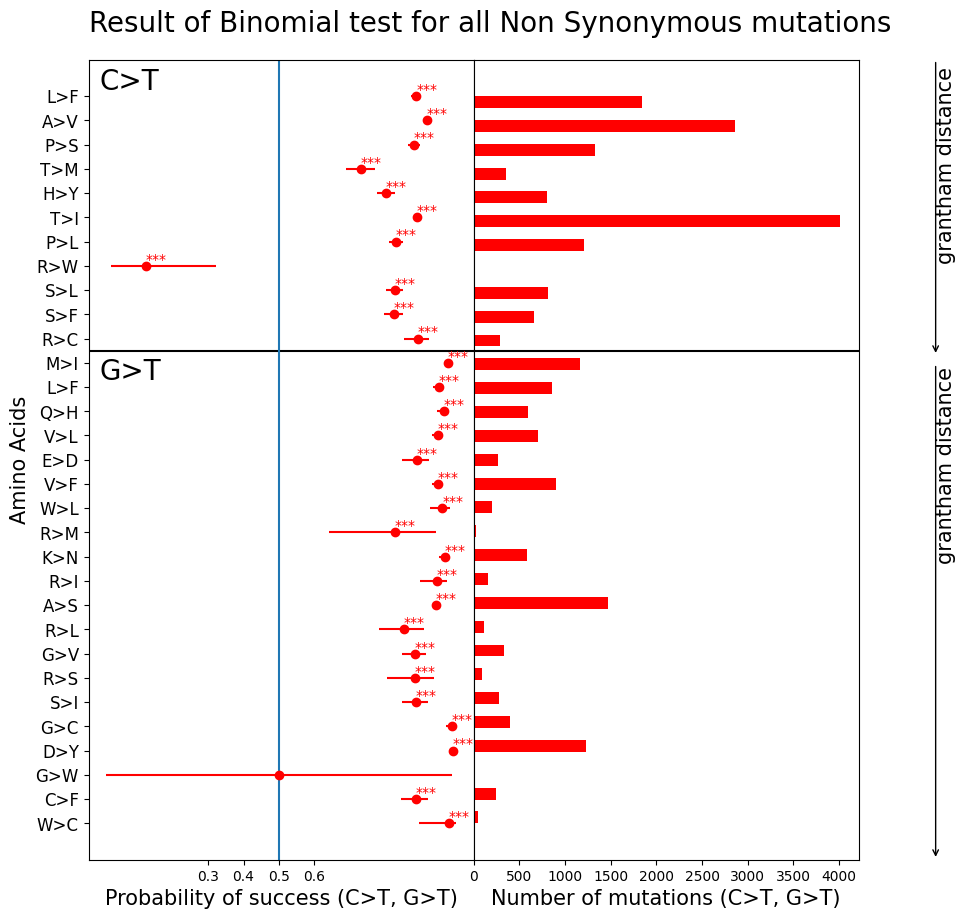

In [99]:
aa_mut_mut_spec = df_aa_mut[df_aa_mut['Mut'].isin(['C>T', 'G>T'])]
aa_mut_mut_spec = aa_mut_mut_spec.sort_values(by=['Mut','gran_dist'], ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(1,2,figsize=(11,10))
min_error = list(aa_mut_mut_spec['prob_success'] - aa_mut_mut_spec['cilow'])
max_error = list(aa_mut_mut_spec['cihigh'] - aa_mut_mut_spec['prob_success'])
error = []
for i in range(len(min_error)):
    error.append([min_error[i], max_error[i]])
error = np.array(error)
aa_mut_mut_spec['color'] = ''
aa_mut_mut_spec.loc[aa_mut_mut_spec['Mut']=='C>T', 'color'] = 'red'
aa_mut_mut_spec.loc[aa_mut_mut_spec['Mut']=='G>T', 'color'] = 'red'

for i in range(len(aa_mut_mut_spec['color'])):
    er = ax[0].errorbar(aa_mut_mut_spec['prob_success'][i], i, xerr=error[i].reshape(2, -1), marker="o", linestyle="none", color=aa_mut_mut_spec['color'][i])

ax[0].set_yticks(np.arange(len(aa_mut_mut_spec['codon_Mut'])))
ax[0].set_yticklabels(aa_mut_mut_spec['codon_Mut'], fontsize=12)

ax[0].set_xlabel('Probability of success (C>T, G>T)', size=15)
ax[0].set_ylabel('Amino Acids', size=15)
# ax.text(5.5,26, 'Odds_ratio with CI 95%')
# ax.text(7,26, 'p_value')
# ax.text(8,26, 'Aa status')

i=0
aa_mut_mut_spec.loc[aa_mut_mut_spec['aster'].isna(),'aster'] = ''
for index, row in aa_mut_mut_spec.iterrows():
    if aa_mut_mut_spec['Mut'][index] == 'C>T':
        ax[0].text(aa_mut_mut_spec['prob_success'][index]-0.001, i+0.1, aa_mut_mut_spec['aster'][index], color='red')
    elif aa_mut_mut_spec['Mut'][index] == 'G>T':
        ax[0].text(aa_mut_mut_spec['prob_success'][index]-0.001, i+0.1, aa_mut_mut_spec['aster'][index], color='red')
    i+=1
#     if aa_statistics_fisher['p_value'][index] < 0.05:
#         ax.text(5.5,i, aa_statistics_fisher['odds_ratio_with_CI'][index], color='red')
#         ax.text(7,i, round(aa_statistics_fisher['p_value'][index],4), color='red')
#         ax.text(8,i, aa_statistics_fisher['aa_status'][index], color='red')
#     else:
#         ax.text(5.5,i, aa_statistics_fisher['odds_ratio_with_CI'][index])
#         ax.text(7,i, round(aa_statistics_fisher['p_value'][index],4))
#         ax.text(8,i, aa_statistics_fisher['aa_status'][index])
#     i = i+1
#  besides ORF1ab or in ORF1ab

ax[0].axhline(y = 19.5, color = 'black', linestyle = '-')
ax[1].axhline(y = 19.55, color = 'black', linestyle = '-')
ax[0].axvline(x=0.5)
ax[0].get_xaxis().set_ticks([0.30, 0.40, 0.50, 0.60])

ax[1].barh(y=range(len(aa_mut_mut_spec['Aa_Mut_count'])), width=aa_mut_mut_spec['Aa_Mut_count'], height = 0.5, color=aa_mut_mut_spec['color'])
#ax[1].barh(y=aa_mut_mut_spec['Aa_Mut'], width=aa_mut_mut_spec['Anti_Aa_Mut_count'], left = aa_mut_mut_spec['Aa_Mut_count'], height = 0.5, color='green')
ax[1].get_yaxis().set_ticks([])
ax[1].set_xlabel('Number of mutations (C>T, G>T)', size=15)
plt.subplots_adjust(left=0.3,
                    bottom=0.1, 
                    right=1.0, 
                    top=0.9, 
                    wspace=0, 
                    hspace=0.4)
fig.suptitle('Result of Binomial test for all Non Synonymous mutations', horizontalalignment='left', x=0.3, y=0.95, fontsize=20)
ax[1].annotate('', xy=(1.2, 1), xycoords='axes fraction', xytext=(1.2, 0.63), 
            arrowprops=dict(arrowstyle="<-", color='black'))

ax[1].annotate('', xy=(1.2, 0.62), xycoords='axes fraction', xytext=(1.2, 0), 
            arrowprops=dict(arrowstyle="<-", color='black'))
plt.text(1.07, 0.7, 'grantham distance', fontsize=15, rotation=90, transform=plt.gcf().transFigure)
plt.text(1.07, 0.4, 'grantham distance', fontsize=15, rotation=90, transform=plt.gcf().transFigure)
plt.text(0.31, 0.87, 'C>T', fontsize=20, transform=plt.gcf().transFigure)
plt.text(0.31, 0.58, 'G>T', fontsize=20, transform=plt.gcf().transFigure)
plt.show()
fig.savefig('../figures/binom_test_CT_GT.pdf', dpi=300, bbox_inches = 'tight')